In [1]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import pandas_ta as ta

In [2]:
#Read in the csv file
csv = pd.read_csv("/home/volatily/market_data/GBPUSD_Daily_20160103_20240131.csv",sep="\t")

In [3]:
#Rename the columns
csv.rename(columns={"<DATE>":"Date","<OPEN>":"Open","<HIGH>":"High","<LOW>":"Low","<CLOSE>":"Close","<TICKVOL>":"TickVol","<VOL>":"Vol","<SPREAD>":"Spread"},inplace=True)

In [4]:
#Define how far into the future we should forecast
look_ahead = 20

In [5]:
#Add the bollinger bands
csv.ta.bbands(length=30,std=2,append=True)

BBL_30_2.0  BBM_30_2.0  BBU_30_2.0  BBB_30_2.0  BBP_30_2.0
0            NaN         NaN         NaN         NaN         NaN
1            NaN         NaN         NaN         NaN         NaN
2            NaN         NaN         NaN         NaN         NaN
3            NaN         NaN         NaN         NaN         NaN
4            NaN         NaN         NaN         NaN         NaN
...          ...         ...         ...         ...         ...
2503    1.264141    1.271139    1.278137    1.101009    0.439337
2504    1.264248    1.271186    1.278124    1.091597    0.390028
2505    1.264313    1.271232    1.278151    1.088553    0.496242
2506    1.264258    1.271201    1.278144    1.092300    0.372455
2507    1.264025    1.271046    1.278066    1.104663    0.277386

[2508 rows x 5 columns]

In [6]:
#Add a column to show the future price
csv["Future Close"] = csv["Close"].shift(-look_ahead)

In [7]:
#Add the normal target, predicting changes in the close price
csv["Price Target"] = 0
csv["Price State"] = 0
#Label the data our conditions
#If price deppreciated, our label is 0 
csv.loc[csv["Close"] < csv["Close"].shift(look_ahead),"Price State"] = 0
csv.loc[csv["Close"] > csv["Future Close"], "Price Target"] = 0
#If price appreciated, our label is 1
csv.loc[csv["Close"] > csv["Close"].shift(look_ahead),"Price State"] = 1
csv.loc[csv["Close"] < csv["Future Close"], "Price Target"] = 1

#Label the bollinger bands
#The label to store the current state of the market
csv["Current State"] = -1
#If price is above the upper band, our label is 1
csv.loc[csv["Close"] > csv["BBU_30_2.0"], "Current State"] = 1
#If price is below the upper band and still above the mid band,our label is 2
csv.loc[(csv["Close"] < csv["BBU_30_2.0"]) & (csv["Close"] > csv["BBM_30_2.0"]),"Current State"] = 2
#If price is below the mid band and still above the low band,our label is 3
csv.loc[(csv["Close"] < csv["BBM_30_2.0"]) & (csv["Close"] > csv["BBL_30_2.0"]),"Current State"] = 3
#Finally, if price is beneath the low band our label is 4
csv.loc[csv["Close"] < csv["BBL_30_2.0"], "Current State"] = 4
#Now we can add a column to denote the future state the market will be in
csv["State Target"] = csv["Current State"].shift(-look_ahead)

In [8]:
#Let's drop any NaN values 
csv.dropna(inplace=True)

<Axes: xlabel='Price State', ylabel='Close'>

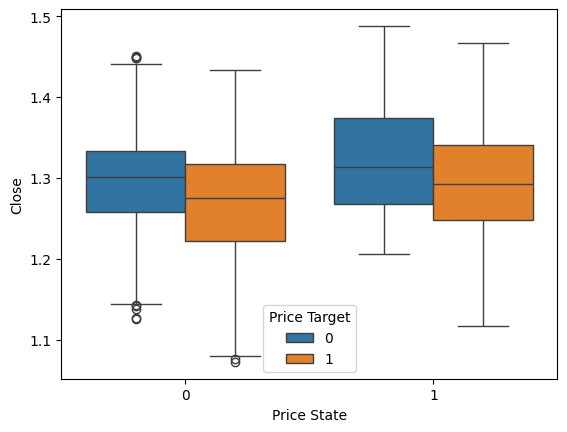

In [25]:
#Notice that the tails of the boxplots have regions where they stop overlaping these zones may guide us as boundaries
sns.boxplot(data=csv,x="Price State",y="Close",hue="Price Target")

<Axes: xlabel='Current State', ylabel='Close'>

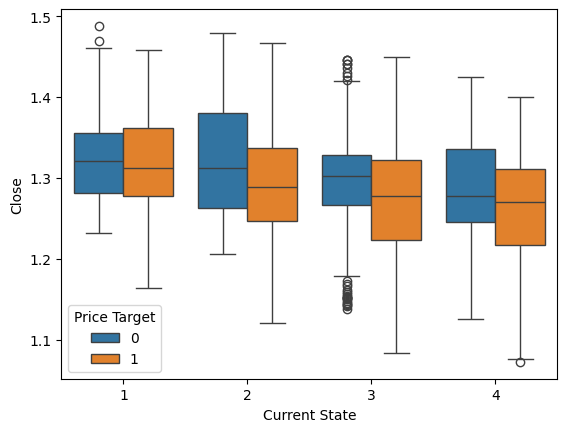

In [27]:
#Notice that the tails of the boxplots have regions where they stop overlaping these zones may guide us as boundaries
sns.boxplot(data=csv,x="Current State",y="Close",hue="Price Target")

<Axes: xlabel='Current State', ylabel='Close'>

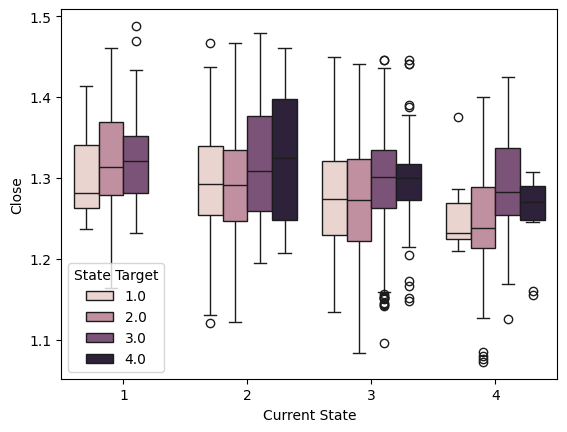

In [28]:
#Notice that the tails of the boxplots have regions where they stop overlaping these zones may guide us as boundaries
sns.boxplot(data=csv,x="Current State",y="Close",hue="State Target")

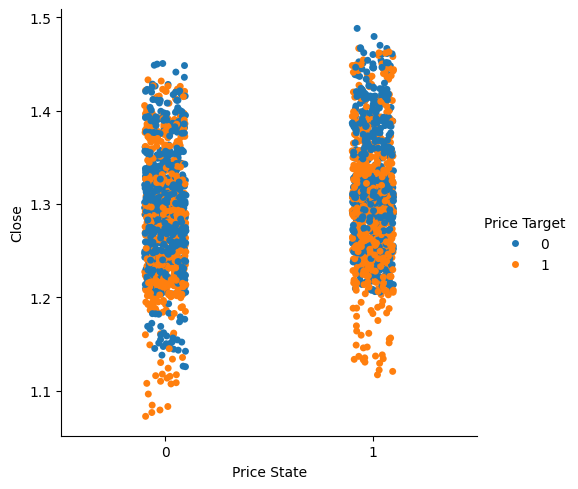

In [24]:
sns.catplot(data=csv,x="Price State",y="Close",hue="Price Target")

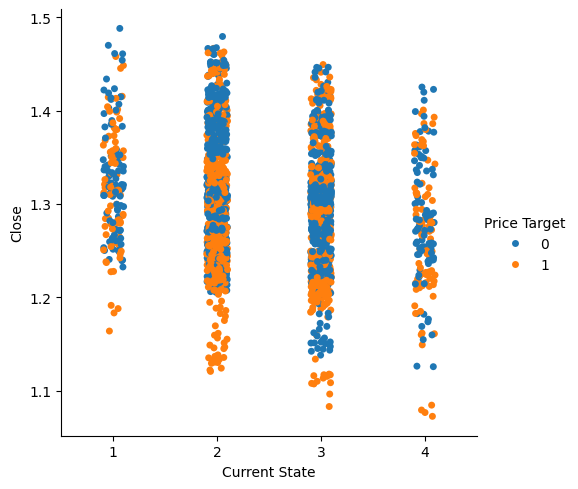

In [15]:
sns.catplot(data=csv,x="Current State",y="Close",hue="Price Target")

<Axes: xlabel='Close', ylabel='Future Close'>

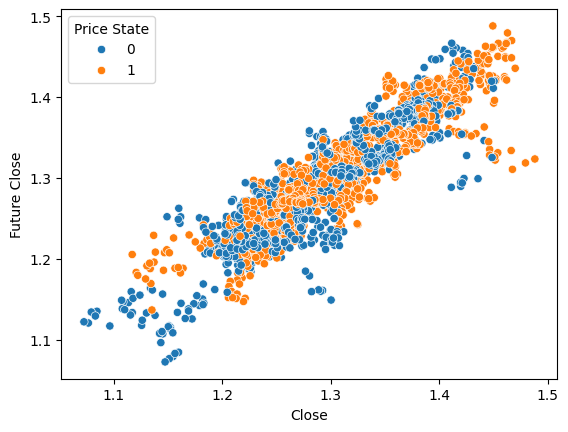

In [10]:
#Notice that using the price target gives us beautiful separation in the data set
sns.scatterplot(data=csv,x="Close",y="Future Close",hue="Price State")

<Axes: xlabel='Close', ylabel='Future Close'>

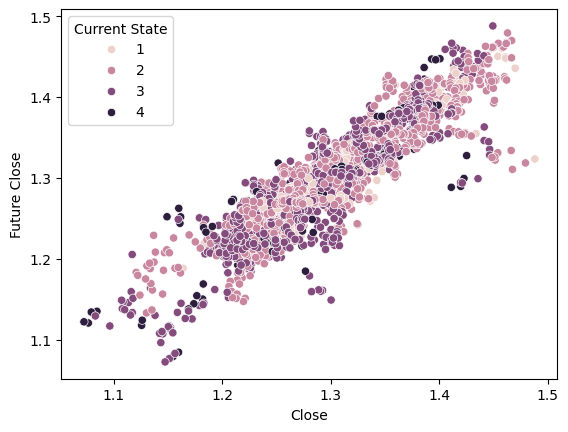

In [11]:
#Using the bollinger bands to define states however gives us rather mixed separation
sns.scatterplot(data=csv,x="Close",y="Future Close",hue="Current State")

In [34]:
#Now let us compare our accuracy forecasting the original price target and the new bollinger bands target
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score

In [35]:
#Now let us define the cross validation parameters
splits = 10
gap = look_ahead

In [36]:
#Now create the cross validation object
tscv = TimeSeriesSplit(n_splits=splits,gap=gap)

In [37]:
#We need a dataframe to store the accuracy associated with each target
target_accuracy = pd.DataFrame(index=np.arange(0,splits),columns=["Price Target Accuracy","New Target Accuracy"])

In [44]:
#Define the inputs
predictors = ["Open","High","Low","Close"]
target = "Price Target"

In [45]:
#Now let us perform the cross validation
for i,(train,test) in enumerate(tscv.split(csv)):
    #First initialize the model
    model = LinearDiscriminantAnalysis()
    #Now train the model
    model.fit(csv.loc[train[0]:train[-1],predictors],csv.loc[train[0]:train[-1],target])
    #Now record the accuracy
    target_accuracy.iloc[i,0] = accuracy_score(csv.loc[test[0]:test[-1],target],model.predict(csv.loc[test[0]:test[-1],predictors]))

In [46]:
target_accuracy

Price Target Accuracy New Target Accuracy
0              0.596413            0.542601
1              0.605381            0.533632
2              0.390135             0.32287
3              0.452915            0.376682
4              0.641256             0.44843
5              0.479821            0.381166
6              0.493274            0.443946
7              0.556054            0.547085
8              0.556054            0.515695
9              0.596413            0.556054